In [1]:
import keras 
import numpy as np 
import pandas as pd 
from lammps import read_traj
from lammps import read_bop

2025-04-14 11:18:03.615110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.manifold import TSNE

Natoms, Config, Box = read_traj("dense_liquid/1st_NN_cutoff_1.5/trajectory.lammpstrj")
BOP_fluid = read_bop("dense_liquid/1st_NN_cutoff_1.5/steinhardt.dat",Natoms)

Natoms, Config, Box = read_traj("quickanddirty_freeze/1st_NN_cutoff_1.5/trajectory.lammpstrj")
BOP_solid = read_bop("quickanddirty_freeze/1st_NN_cutoff_1.5/steinhardt.dat",Natoms)


x_train=[]
for ti in range(0, 30):
    for id in range(len(BOP_solid[ti])):
        x_train.append(BOP_solid[ti][id][1:])

for ti in range(0,30):
    for id in range(len(BOP_fluid[ti])):
        x_train.append(BOP_fluid[ti][id][1:])

x_test=[]
for ti in range(30,40):
    for id in range(len(BOP_solid[ti])):
        x_test.append(BOP_solid[ti][id][1:])

for ti in range(30,40):
    for id in range(len(BOP_fluid[ti])):
        x_test.append(BOP_fluid[ti][id][1:])

x_train = np.array(x_train)
x_test = np.array(x_test)



X_embedded = TSNE(n_components=2, learning_rate='auto',

                  init='random', perplexity=50).fit_transform(x_train)

X_embedded.shape

(60000, 2)

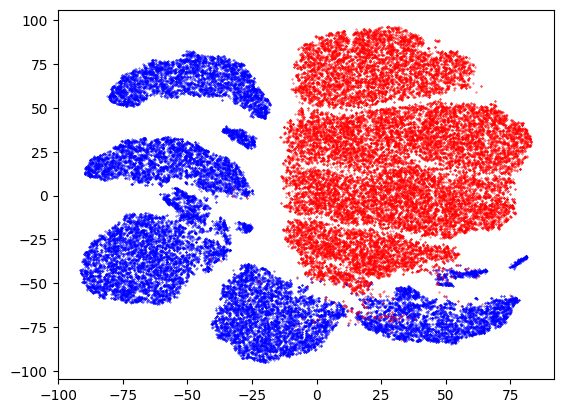

In [3]:
import matplotlib.pyplot as plt 
plt.scatter(X_embedded[:30000,0],X_embedded[:30000,1],c='b', s=0.1)
plt.scatter(X_embedded[30000:,0],X_embedded[30000:,1],c='r', s=0.1)

## Simple autoencoder

In [2]:
import keras
from keras import layers

def autoencoder(encoding_dim,input_dim,x_test,x_train):

    # This is our input image
    input_img = keras.Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_img, decoded)


    # This model maps an input to its encoded representation
    encoder = keras.Model(input_img, encoded)


    # This is our encoded (32-dimensional) input
    encoded_input = keras.Input(shape=(encoding_dim,))
    # Retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    # Encode and decode some digits
    # Note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)


    return encoded_imgs, decoded_imgs 


2025-04-22 11:48:39.923023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 

## Autoencoder for LJ crystallisation with liquid and solid Q1-Q8 with first neighbouring shell 

In [1]:

import numpy as np 
from lammps import read_traj
from lammps import read_bop

Natoms, Config, Box = read_traj("dense_liquid/1st_NN_cutoff_1.5/trajectory.lammpstrj")
BOP_fluid = read_bop("dense_liquid/1st_NN_cutoff_1.5/steinhardt.dat",Natoms)

Natoms, Config, Box = read_traj("quickanddirty_freeze/1st_NN_cutoff_1.5/trajectory.lammpstrj")
BOP_solid = read_bop("quickanddirty_freeze/1st_NN_cutoff_1.5/steinhardt.dat",Natoms)


x_train=[]
for ti in range(0, 30):
    for id in range(len(BOP_solid[ti])):
        x_train.append(BOP_solid[ti][id][1:])

for ti in range(0, 30):
    for id in range(len(BOP_fluid[ti])):
        x_train.append(BOP_fluid[ti][id][1:])

x_test=[]
for ti in range(30,40):
    for id in range(len(BOP_solid[ti])):
        x_test.append(BOP_solid[ti][id][1:])

for ti in range(30,40):
    for id in range(len(BOP_fluid[ti])):
        x_test.append(BOP_fluid[ti][id][1:])

x_train = np.array(x_train)
x_test = np.array(x_test)


print(x_train)
print(x_test)

encoded_imgs, decoded_imgs = autoencoder(3,8,x_test,x_train)



[[0.0577219 0.0532705 0.0822999 ... 0.262172  0.309625  0.348975 ]
 [0.0603473 0.0552507 0.0863564 ... 0.341029  0.209541  0.433574 ]
 [0.0598047 0.0626649 0.0457382 ... 0.298357  0.117284  0.461801 ]
 ...
 [0.159571  0.12952   0.212304  ... 0.323291  0.37044   0.278702 ]
 [0.106535  0.106303  0.0695061 ... 0.279243  0.422637  0.276881 ]
 [0.0798916 0.119584  0.123221  ... 0.395718  0.323328  0.330383 ]]
[[0.0451738 0.0807798 0.107506  ... 0.3149    0.297976  0.347832 ]
 [0.0177238 0.0139271 0.0291377 ... 0.257341  0.0927119 0.48898  ]
 [0.0523855 0.0334794 0.048552  ... 0.210451  0.216068  0.377221 ]
 ...
 [0.105142  0.0733082 0.123764  ... 0.357757  0.362465  0.303914 ]
 [0.0328431 0.0751122 0.0511113 ... 0.538729  0.194455  0.219864 ]
 [0.102262  0.0662441 0.133821  ... 0.388273  0.367054  0.238653 ]]


NameError: name 'autoencoder' is not defined

[[0.6221316  1.5736578  0.        ]
 [0.05438332 1.3978387  0.        ]
 [0.39609116 1.5525888  0.        ]
 ...
 [0.78621125 1.3073611  0.        ]
 [0.4482507  0.9516686  0.        ]
 [0.8158227  1.186893   0.        ]]
(20000, 3)
20000


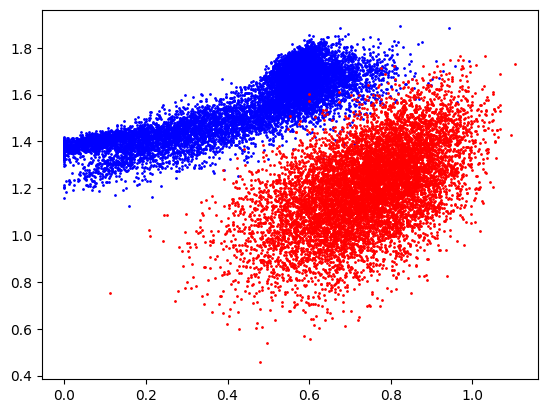

In [13]:
print(encoded_imgs)
print(encoded_imgs.shape)
print(len(encoded_imgs))
#plt.scatter(encoded_imgs[:,0]+np.random.rand(len(encoded_imgs[:,0])),encoded_imgs[:,1], s=1)
plt.scatter(encoded_imgs[:10000,0],encoded_imgs[:10000,1],c='b', s=1)
plt.scatter(encoded_imgs[10000:,0],encoded_imgs[10000:,1],c='r', s=1)
plt.show()

(0.0, 0.5)

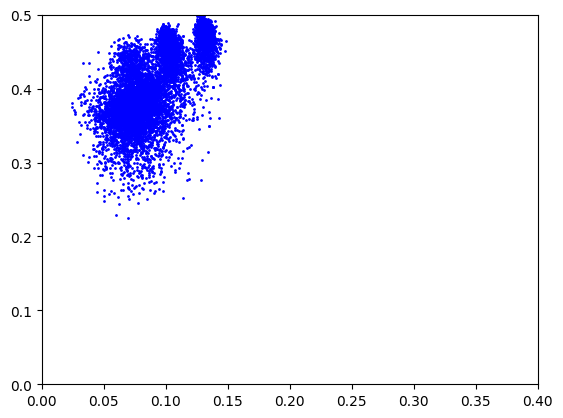

In [7]:
x_s=[]
for ti in range(30, 40):
    for id in range(len(BOP_solid[ti])):
        x_s.append(BOP_solid[ti][id][1:])

x_s = np.array(x_s)
plt.scatter(x_s[:,3],x_s[:,7], s=1,c='b')
plt.xlim((0,0.4))
plt.ylim((0,0.5))


[[0.0577219 0.0532705 0.0822999 ... 0.262172  0.309625  0.348975 ]
 [0.0603473 0.0552507 0.0863564 ... 0.341029  0.209541  0.433574 ]
 [0.0598047 0.0626649 0.0457382 ... 0.298357  0.117284  0.461801 ]
 ...
 [0.159571  0.12952   0.212304  ... 0.323291  0.37044   0.278702 ]
 [0.106535  0.106303  0.0695061 ... 0.279243  0.422637  0.276881 ]
 [0.0798916 0.119584  0.123221  ... 0.395718  0.323328  0.330383 ]]


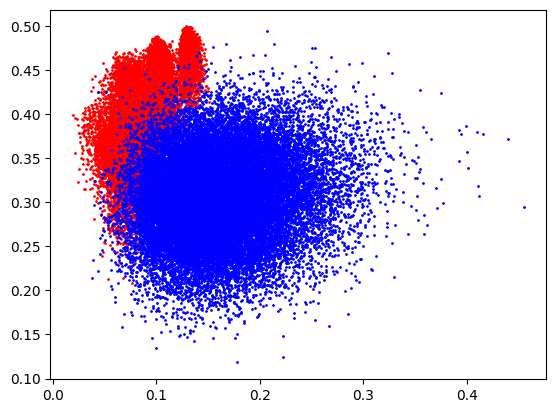

In [8]:
print(x_train)

plt.scatter(x_train[:30000,3],x_train[:30000,7], c='r', s=1)
plt.scatter(x_train[30000:,3],x_train[30000:,7], c='b', s=1)

### Autoencoder with raw distances 

In [22]:
from lammps import distances, neighbours, read_traj, nextN_neighbours
from scipy.spatial.distance import squareform
import numpy as np 

nn=8

Natoms, Config, Box = read_traj("dense_liquid/1st_NN_cutoff_1.5/trajectory.lammpstrj")
xr_train=[]
for ti in range(0, 30):
    dist = distances(Config[ti]*Box[ti], Box[ti])
    dist_squareform = squareform(dist)
    nextN = nextN_neighbours(Natoms, dist_squareform,nn)

    for id in range(len(Config[ti])):
        xr_train.append(nextN[id])

xr_test=[]
for ti in range(30,40):
    dist = distances(Config[ti]*Box[ti], Box[ti])
    dist_squareform = squareform(dist)
    nextN = nextN_neighbours(Natoms, dist_squareform,nn)

    for id in range(len(Config[ti])):
        xr_test.append(nextN[id])
      
Natoms, Config, Box = read_traj("quickanddirty_freeze/1st_NN_cutoff_1.5/trajectory.lammpstrj")
for ti in range(0, 30):
    dist = distances(Config[ti]*Box[ti], Box[ti])
    dist_squareform = squareform(dist)
    nextN = nextN_neighbours(Natoms, dist_squareform,nn)

    for id in range(len(Config[ti])):
        xr_train.append(nextN[id])
    
for ti in range(30, 40):
    dist = distances(Config[ti]*Box[ti], Box[ti])
    dist_squareform = squareform(dist)
    nextN = nextN_neighbours(Natoms, dist_squareform,nn)

    for id in range(len(Config[ti])):
        xr_test.append(nextN[id])

xr_train = np.array(xr_train)
xr_test = np.array(xr_test)



In [23]:
rencoded_imgs, rdecoded_imgs = autoencoder(3,nn,xr_test,xr_train)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2032 - val_loss: 0.0331
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 0.0121
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - val_loss: 0.0101
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

[[7.202858  2.3219557 3.8062556]
 [7.351758  2.413419  3.887557 ]
 [6.994272  2.1933782 3.6618812]
 ...
 [6.30267   1.7991717 3.2579048]
 [6.131403  1.6993136 3.1437376]
 [6.3751907 1.8383286 3.2882001]]
(20000, 3)
20000


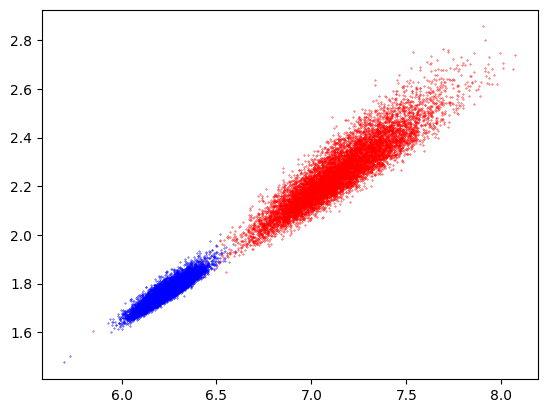

In [25]:

import matplotlib.pyplot as plt
print(rencoded_imgs)
print(rencoded_imgs.shape)
print(len(encoded_imgs))
plt.scatter(rencoded_imgs[:10000,0],rencoded_imgs[:10000,1], s=0.1, c='r')
plt.scatter(rencoded_imgs[10000:,0],rencoded_imgs[10000:,1], s=0.1, c='b')
plt.show()


In [26]:
Xr_embedded = TSNE(n_components=2, learning_rate='auto',

                  init='random', perplexity=3).fit_transform(xr_train)


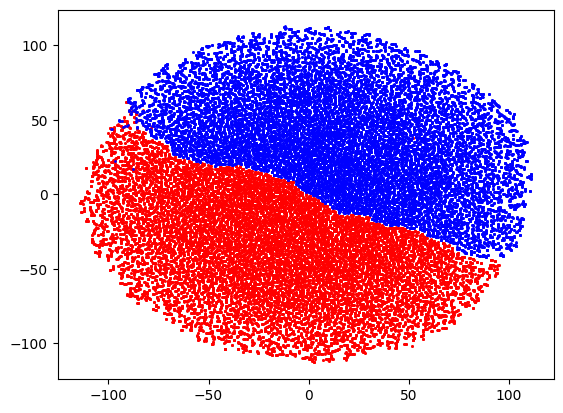

In [27]:
import matplotlib.pyplot as plt 
plt.scatter(Xr_embedded[:30000,0],Xr_embedded[:30000,1], s=1,c='r')
plt.scatter(Xr_embedded[30000:,0],Xr_embedded[30000:,1], s=1,c='b')


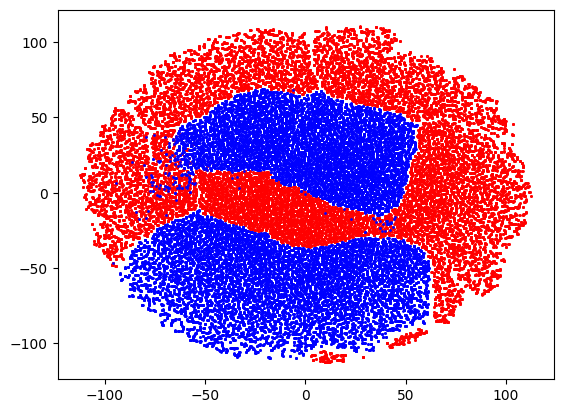

In [18]:
X_rembedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(x_train)


import matplotlib.pyplot as plt 
plt.scatter(Xr_embedded[:30000,0],Xr_embedded[:30000,1], s=1,c='r')
plt.scatter(Xr_embedded[30000:,0],Xr_embedded[30000:,1], s=1,c='b')


## Next plans 
* make fcc/bcc/hcp lattice of lj spheres at specific density
* make very dense liquid 
* try simple autoendoer with distance vectors

## Autoencoder with distance vectors 

In [28]:
import keras
from keras import layers
import numpy as np

def autoencoder_conv1d(encoding_dim, n_features, x_test, x_train):
    input_img = keras.Input(shape=(n_features, 3))

    # ----- Encoder -----
    x = layers.Conv1D(16, kernel_size=3, padding='same', activation='relu')(input_img)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(x)

    # ----- Decoder -----
    x = layers.Dense(n_features * 32, activation='relu')(encoded)
    x = layers.Reshape((n_features, 32))(x)
    x = layers.Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
    decoded = layers.Conv1D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

    # Full autoencoder model
    autoencoder = keras.Model(input_img, decoded)

    # Encoder model
    encoder = keras.Model(input_img, encoded)

    # Rebuild decoder model from scratch
    encoded_input = keras.Input(shape=(encoding_dim,))
    x = layers.Dense(n_features * 32, activation='relu')(encoded_input)
    x = layers.Reshape((n_features, 32))(x)
    x = layers.Conv1D(16, kernel_size=3, padding='same', activation='relu')(x)
    decoded_output = layers.Conv1D(3, kernel_size=3, padding='same', activation='sigmoid')(x)
    decoder = keras.Model(encoded_input, decoded_output)

    # Compile and train
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    # Use encoder and decoder
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    return encoded_imgs, decoded_imgs


from keras import Input, Model, layers
import numpy as np

def simple_dense_autoencoder(encoding_dim, n_features, x_test, x_train):
    input_dim = n_features * 3

    # Flattened input
    input_img = Input(shape=(n_features, 3))
    flat = layers.Flatten()(input_img)  # (batch_size, n_features*3)

    # Encoder
    encoded = layers.Dense(encoding_dim, activation='relu')(flat)

    # Decoder
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    decoded_reshaped = layers.Reshape((n_features, 3))(decoded)

    # Models
    autoencoder = Model(input_img, decoded_reshaped)
    encoder = Model(input_img, encoded)

    # Decoder as separate model
    encoded_input = Input(shape=(encoding_dim,))
    x = layers.Dense(input_dim, activation='sigmoid')(encoded_input)
    decoded_output = layers.Reshape((n_features, 3))(x)
    decoder = Model(encoded_input, decoded_output)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    return encoded_imgs, decoded_imgs
    

In [29]:
from lammps import distances, neighbours, read_traj, nextN_neighbours, vector_squareform_distances, nextN_neighbours_vector
from scipy.spatial.distance import squareform
import numpy as np 

nn=12

def get_data(ti,Config,Box,Natoms,nn):  
    dist, vdist = vector_squareform_distances(Config[ti]*Box[ti], Box[ti])
    dist = np.array(dist).reshape((Natoms,Natoms))
    vdist = np.array(vdist).reshape((Natoms,Natoms,3))
    nextN = nextN_neighbours_vector(Natoms, dist,vdist, nn)
    return nextN    

Natoms, Config, Box = read_traj("dense_liquid/1st_NN_cutoff_1.5/trajectory.lammpstrj")
Natoms = int(Natoms)
xrv_train=[]
for ti in range(60, 90):
    nextN = get_data(ti,Config,Box,Natoms,nn) 
    for id in range(len(Config[ti])):
        xrv_train.append(nextN[id])

xrv_test=[]
for ti in range(90, 100):
    nextN = get_data(ti,Config,Box,Natoms,nn) 
    for id in range(len(Config[ti])):
        xrv_test.append(nextN[id])
      
Natoms, Config, Box = read_traj("quickanddirty_freeze/1st_NN_cutoff_1.5/trajectory.lammpstrj")
Natoms = int(Natoms)
for ti in range(0, 30):
    nextN = get_data(ti,Config,Box,Natoms,nn)  
    for id in range(len(Config[ti])):
        xrv_train.append(nextN[id])
    
for ti in range(30, 40):
    nextN = get_data(ti,Config,Box,Natoms,nn)  
    for id in range(len(Config[ti])):
        xrv_test.append(nextN[id])

xrv_train = np.array(xrv_train)
xrv_test = np.array(xrv_test)






In [30]:
nn=12
rvencoded_imgs, rvdecoded_imgs =  autoencoder_conv1d(2, nn, xrv_test, xrv_train)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4764 - val_loss: 0.3942
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3904 - val_loss: 0.3764
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3733 - val_loss: 0.3694
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3665 - val_loss: 0.3656
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3637 - val_loss: 0.3641
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3635 - val_loss: 0.3634
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3620 - val_loss: 0.3626
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3615 - val_loss: 0.3623
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3620 - val_loss: 0.3620
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3611 - val_loss: 0.3616
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3612 - val_loss: 0.3614
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

[[41.610806   8.736941 ]
 [ 1.350417   2.5504813]
 [27.965979  35.081455 ]
 ...
 [33.71827   27.871563 ]
 [ 2.6402304 32.88778  ]
 [ 6.4197097  3.2950244]]
(20000, 2)
20000


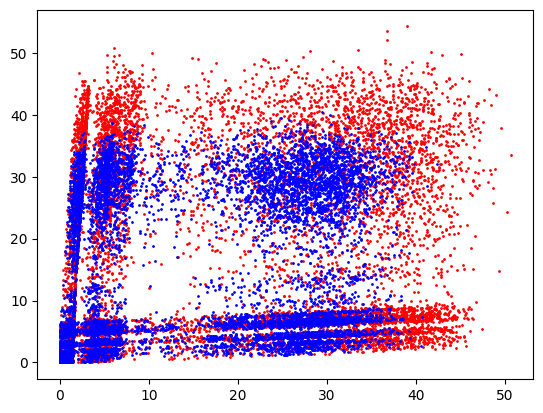

In [31]:

import matplotlib.pyplot as plt
print(rvencoded_imgs)
print(rvencoded_imgs.shape)
print(len(encoded_imgs))
plt.scatter(rvencoded_imgs[:10000,0],rvencoded_imgs[:10000,1],c='r', s=1)
plt.scatter(rvencoded_imgs[10000:,0],rvencoded_imgs[10000:,1],c='b', s=1)
plt.show()


In [32]:

rvencoded_imgs, rvdecoded_imgs = simple_dense_autoencoder(2, 12, xrv_test, xrv_train)
    

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6288 - val_loss: 0.5374
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5083 - val_loss: 0.4452
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4347 - val_loss: 0.4124
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4078 - val_loss: 0.3992
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3969 - val_loss: 0.3933
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3916 - val_loss: 0.3901
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3893 - val_loss: 0.3880
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3876 - val_loss: 0.3865
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3860 - val_loss: 0.3853
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3841 - val_loss: 0.3844
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3836 - val_loss: 0.3836
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

[[3.7760544  6.5360336 ]
 [1.9868662  0.89275146]
 [2.1623197  6.4413757 ]
 ...
 [4.9402056  5.615311  ]
 [4.9863777  2.7856178 ]
 [3.6983893  1.7654178 ]]
(20000, 2)
20000


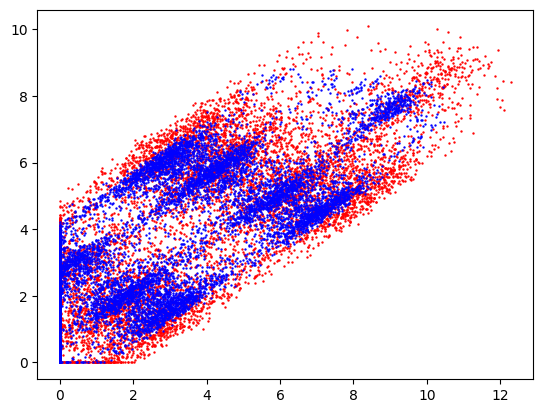

In [ ]:
import matplotlib.pyplot as plt
print(rvencoded_imgs)
print(rvencoded_imgs.shape)
print(len(rvencoded_imgs))
plt.scatter(rvencoded_imgs[:10000,0],rvencoded_imgs[:10000,1],c='r', s=0.5)
plt.scatter(rvencoded_imgs[10000:,0],rvencoded_imgs[10000:,1],c='b', s=0.5)

plt.show()


In [33]:
rvsencoded_imgs, rvsdecoded_imgs = simple_dense_autoencoder(3, 12, xrv_test, xrv_train)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6218 - val_loss: 0.5115
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4801 - val_loss: 0.4206
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4113 - val_loss: 0.3971
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3932 - val_loss: 0.3887
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3870 - val_loss: 0.3844
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3829 - val_loss: 0.3819
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3806 - val_loss: 0.3802
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3794 - val_loss: 0.3788
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3779 - val_loss: 0.3776
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3762 - val_loss: 0.3763
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3757 - val_loss: 0.3748
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

[[1.566824   3.5465205  2.5516932 ]
 [1.5669584  2.0300243  0.47181964]
 [2.5585904  4.101062   6.1221395 ]
 ...
 [3.5268278  3.5899522  4.6180725 ]
 [3.8997204  1.104018   4.34935   ]
 [3.9241195  3.6772194  1.615512  ]]
(20000, 3)
20000


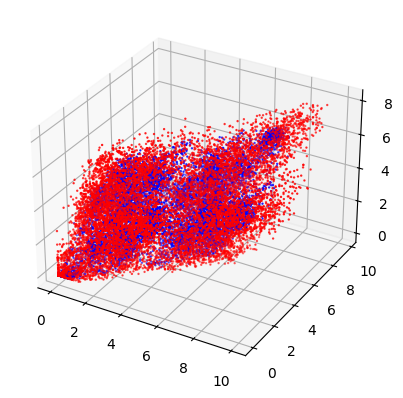

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print(rvsencoded_imgs)
print(rvsencoded_imgs.shape)
print(len(rvsencoded_imgs))
ax.scatter(rvsencoded_imgs[:10000,0],rvsencoded_imgs[:10000,1], rvsencoded_imgs[:10000,2], c='r', s=0.5)
ax.scatter(rvsencoded_imgs[10000:,0],rvsencoded_imgs[10000:,1], rvsencoded_imgs[10000:,2], c='b', s=0.5)

plt.show()

In [2]:
import numpy as np 
arr = np.array([[1,2,3],[4,5,6],[7,8,9]])
brr = np.array([2,3,4])

arr*brr

array([[ 2,  6, 12],
       [ 8, 15, 24],
       [14, 24, 36]])

## Results of q1-q8 with fcc, bcc, hcp, and liquid 


In [5]:
import keras
from keras import layers

def autoencoder(encoding_dim,input_dim,x_test,x_train):

    # This is our input image
    input_img = keras.Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_img, decoded)


    # This model maps an input to its encoded representation
    encoder = keras.Model(input_img, encoded)


    # This is our encoded (32-dimensional) input
    encoded_input = keras.Input(shape=(encoding_dim,))
    # Retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    # Encode and decode some digits
    # Note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)


    return encoded_imgs, decoded_imgs 

2025-04-23 14:45:05.132983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
import numpy as np 
from lammps import read_traj
from lammps import read_bop


x_train = []
x_test = []

train_start=60
train_end=90

test_start = 90
test_end = 100 


filenames = ["liquid_density_1.1", "fcc_perfect", "hcp_perfect", "bcc_perfect"]
for filename in filenames:
    Natoms, Config, Box = read_traj("{}/trajectory.lammpstrj".format(filename))
    print(Natoms, filename)
    bop = read_bop("{}/steinhardt.dat".format(filename),Natoms)
    
    for ti in range(train_start, train_end):
        for id in range(len(bop[ti])):
            x_train.append(bop[ti][id][1:])
            
    
    for ti in range(test_start, test_end):
        for id in range(len(bop[ti])):
            x_test.append(bop[ti][id][1:])
            

x_train = np.array(x_train)
x_test = np.array(x_test)



1000.0 liquid_density_1.1
4000.0 fcc_perfect
4000.0 hcp_perfect
2000.0 bcc_perfect


In [7]:
encoded_imgs, decoded_imgs = autoencoder(3,8,x_test,x_train)

Epoch 1/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0703 - val_loss: 0.0018
Epoch 2/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013 - val_loss: 9.2693e-04
Epoch 3/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.1803e-04 - val_loss: 8.9810e-04
Epoch 4/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.9471e-04 - val_loss: 8.7437e-04
Epoch 5/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6905e-04 - val_loss: 8.3587e-04
Epoch 6/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2251e-04 - val_loss: 7.5776e-04
Epoch 7/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2827e-04 - val_loss: 6.3281e-04
Epoch 8/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1282e-04 - val_loss: 5.5921e-04
Epoch 9/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.4866e-04 - val_loss: 5.1601e-04
Epoch 10/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.0843e-04 - val_loss: 4.8953e-04
Epoch 11/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/s

[[1.1013808  0.29008442 0.        ]
 [1.1285164  0.49541113 0.        ]
 [1.1349912  0.5424248  0.        ]
 ...
 [0.88290894 0.6737628  0.        ]
 [1.0426736  0.4323015  0.        ]
 [0.8515485  0.7394955  0.        ]]
(110000, 3)
110000


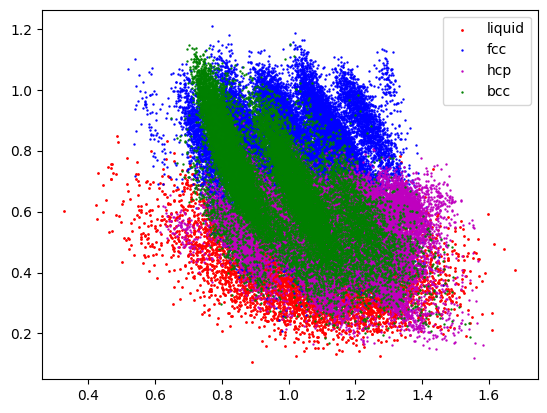

In [16]:
import matplotlib.pyplot as plt

print(encoded_imgs)
print(encoded_imgs.shape)
print(len(encoded_imgs))

plt.scatter(encoded_imgs[:10000,0],encoded_imgs[:10000,1],c='r', s=1, label="liquid")
plt.scatter(encoded_imgs[10000:50000,0],encoded_imgs[10000:50000,1],c='b', s=0.5, label="fcc")
plt.scatter(encoded_imgs[50000:90000,0],encoded_imgs[50000:90000,1],c='m', s=0.5, label="hcp")
plt.scatter(encoded_imgs[90000:110000,0],encoded_imgs[90000:110000,1],c='g', s=0.5, label="bcc")
plt.legend(loc="best")
plt.show()

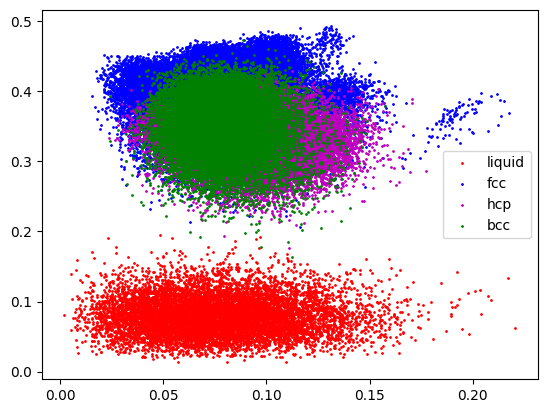

In [13]:
import matplotlib.pyplot as plt


plt.scatter(x_test[:10000,0],x_test[:10000,1],c='r', s=1, label="liquid")
plt.scatter(x_test[10000:50000,3],x_test[10000:50000,7],c='b', s=1, label="fcc")
plt.scatter(x_test[50000:90000,3],x_test[50000:90000,7],c='m', s=1, label="hcp")
plt.scatter(x_test[90000:110000,3],x_test[90000:110000,7],c='g', s=1, label="bcc")
plt.legend(loc="best")
plt.show()

## Results of q1-q20 for liquid, fcc, hcp, and bcc 

In [3]:
import numpy as np 
from lammps import read_traj
from lammps import read_bop


qx_train = []
qx_test = []

train_start=60
train_end=90

test_start = 90
test_end = 100 


filenames = ["liquid_density_1.1", "fcc_perfect", "hcp_perfect", "bcc_perfect"]
for filename in filenames:
    Natoms, Config, Box = read_traj("{}/first_neighbour_shell_cutoff_1.5/trajectory.lammpstrj".format(filename))
    print(Natoms, filename)
    bop = read_bop("{}/first_neighbour_shell_cutoff_1.5/steinhardt.dat".format(filename),Natoms)
    
    for ti in range(train_start, train_end):
        for id in range(len(bop[ti])):
            qx_train.append(bop[ti][id][1:])
            
    
    for ti in range(test_start, test_end):
        for id in range(len(bop[ti])):
            qx_test.append(bop[ti][id][1:])
            

qx_train = np.array(qx_train)
qx_test = np.array(qx_test)



1000.0 liquid_density_1.1
4000.0 fcc_perfect
4000.0 hcp_perfect
2000.0 bcc_perfect


In [7]:

Q_rembedding, qdecoded_imgs = autoencoder(2,20,qx_test,qx_train)

Epoch 1/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0348 - val_loss: 0.0016
Epoch 2/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0010 - val_loss: 9.7830e-04
Epoch 6/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.6382e-04 - val_loss: 9.1791e-04
Epoch 7/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.0217e-04 - val_loss: 8.5297e-04
Epoch 8/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.3790e-04 - val_loss: 7.9819e-04
Epoch 9/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8971e-04 - val_loss: 7.6914e-04
Epoch 10/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.6524e-04 - val_loss: 7.5555e-04
Epoch 11/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.5403e-04 -

[[1.1558211  0.5992825 ]
 [1.0922794  0.75997627]
 [1.1275872  0.7795352 ]
 ...
 [0.9157378  0.81818914]
 [1.0273316  0.63274384]
 [0.8257481  0.8679967 ]]
(110000, 2)
110000


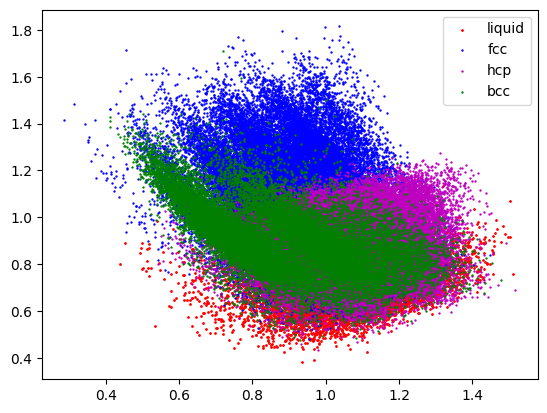

In [ ]:
import matplotlib.pyplot as plt

print(Q_rembedding)
print(Q_rembedding.shape)
print(len(Q_rembedding))

plt.scatter(Q_rembedding[:30000,0],Q_rembedding[:30000,1],c='r', s=1, label="liquid")
plt.scatter(Q_rembedding[30000:150000,0],Q_rembedding[30000:150000,1],c='b', s=0.5, label="fcc")
plt.scatter(Q_rembedding[150000:270000,0],Q_rembedding[150000:270000,1],c='m', s=0.5, label="hcp")
plt.scatter(Q_rembedding[270000:330000,0],Q_rembedding[270000:330000,1],c='g', s=0.5, label="bcc")
plt.legend(loc="best")
plt.show()

In [10]:
Q_rembedding, qdecoded_imgs = autoencoder(2,10,qx_test[:,10:],qx_train[:,10:])

Epoch 1/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0225 - val_loss: 0.0016
Epoch 2/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011 - val_loss: 9.6712e-04
Epoch 10/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.4109e-04 - val_loss: 9.0616e-04
Epoch 11/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.9908e-04 - val_loss: 8.9510e-04
Epoch 12/5

[[0.         0.52660644]
 [0.         0.6100722 ]
 [0.         0.5212156 ]
 ...
 [0.         0.49276406]
 [0.         0.43674767]
 [0.         0.52873284]]
(110000, 2)
110000


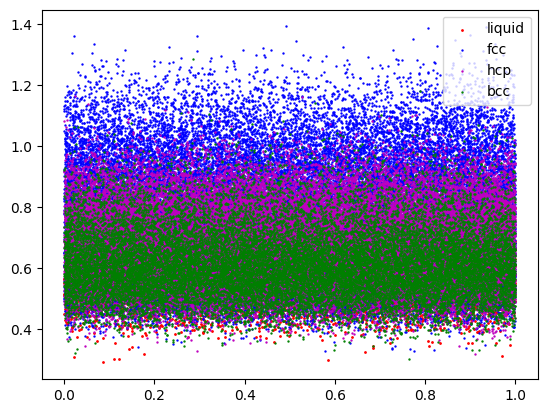

In [ ]:
import matplotlib.pyplot as plt

print(Q_rembedding)
print(Q_rembedding.shape)
print(len(Q_rembedding))

plt.scatter(np.random.rand(10000)+Q_rembedding[:10000,0],Q_rembedding[:10000,1],c='r', s=1, label="liquid")
plt.scatter(np.random.rand(40000)+Q_rembedding[10000:50000,0],Q_rembedding[10000:50000,1],c='b', s=0.5, label="fcc")
plt.scatter(np.random.rand(40000)+Q_rembedding[50000:90000,0],Q_rembedding[50000:90000,1],c='m', s=0.5, label="hcp")
plt.scatter(np.random.rand(20000)+Q_rembedding[90000:110000,0],Q_rembedding[90000:110000,1],c='g', s=0.5, label="bcc")
plt.legend(loc="best")
plt.show()

In [ ]:
Q_rembedding, qdecoded_imgs = autoencoder(3,20,qx_test,qx_train)

Epoch 1/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0480 - val_loss: 0.0017
Epoch 2/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.9968e-04 - val_loss: 9.9423e-04
Epoch 11/50
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.9384e-04 - val_loss: 9.8931e-04
Epoch 12/50
12

[[0.        1.4815257 0.       ]
 [0.        1.7055774 0.       ]
 [0.        1.7094516 0.       ]
 ...
 [0.        1.8839456 0.       ]
 [0.        1.5977156 0.       ]
 [0.        1.9988    0.       ]]
(110000, 3)
110000


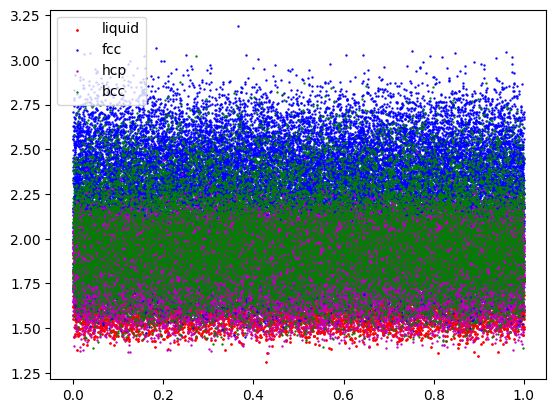

In [20]:


import matplotlib.pyplot as plt

print(Q_rembedding)
print(Q_rembedding.shape)
print(len(Q_rembedding))

plt.scatter(np.random.rand(10000)+Q_rembedding[:10000,0],Q_rembedding[:10000,1],c='r', s=1, label="liquid")
plt.scatter(np.random.rand(40000)+Q_rembedding[10000:50000,0],Q_rembedding[10000:50000,1],c='b', s=0.5, label="fcc")
plt.scatter(np.random.rand(40000)+Q_rembedding[50000:90000,0],Q_rembedding[50000:90000,1],c='m', s=0.5, label="hcp")
plt.scatter(np.random.rand(20000)+Q_rembedding[90000:110000,0],Q_rembedding[90000:110000,1],c='g', s=0.5, label="bcc")
plt.legend(loc="best")
plt.show()

In [27]:

from sklearn.manifold import TSNE

Q_rembedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(qx_test)





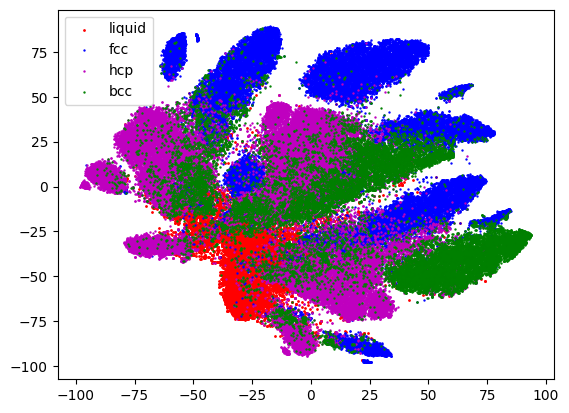

In [28]:
import matplotlib.pyplot as plt 
plt.scatter(Q_rembedding[:10000,0],Q_rembedding[:10000,1],c='r', s=1, label="liquid")
plt.scatter(Q_rembedding[10000:50000,0],Q_rembedding[10000:50000,1],c='b', s=0.5, label="fcc")
plt.scatter(Q_rembedding[50000:90000,0],Q_rembedding[50000:90000,1],c='m', s=0.5, label="hcp")
plt.scatter(Q_rembedding[90000:110000,0],Q_rembedding[90000:110000,1],c='g', s=0.5, label="bcc")
plt.legend(loc="best")
plt.show()


In [ ]:

from sklearn import manifold 
from sklearn.utils import shuffle
import numpy as np 

Nx=len(qx_test)
qx_label = np.array(["none"]*Nx)
qx_label[:10000] = "liquid"
qx_label[10000:50000] = "fcc"
qx_label[50000:90000] = "hcp"
qx_label[90000:110000] = "bcc"

Xq, yq = shuffle(qx_test, qx_label, random_state=0)


md_scaling = manifold.MDS(
    n_components=2,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
S_scaleing = md_scaling.fit_transform(Xq[:10000])

import matplotlib.pyplot as plt 
color_dict = { 'liquid':'red', 'fcc':'blue', 'hcp':'magenta', 'bcc':'green'}
plt.scatter( S_scaleing[:,0], S_scaleing[:,1], color=[ color_dict[i] for i in yq[:10000] ] )
plt.legend(loc="best")
plt.show()



In [5]:
import numpy as np
arr=np.array(range(10))
arr[:3] = 1 
arr

array([1, 1, 1, 3, 4, 5, 6, 7, 8, 9])

## Raw distances for liquid, fcc, hcp and bcc 

In [ ]:
from lammps import distances, neighbours, read_traj, nextN_neighbours
from scipy.spatial.distance import squareform
import numpy as np 

nn=12

def get_nn(Config,Box,Natoms,nn,ti):
    dist = distances(Config[ti]*Box[ti], Box[ti])
    dist_squareform = squareform(dist)
    nextN = nextN_neighbours(Natoms, dist_squareform,nn)
    return nextN

tqx_train = []
tqx_test = []

train_start=60
train_end=90

test_start = 90
test_end = 100 


filenames = ["liquid_density_1.1", "fcc_perfect", "hcp_perfect", "bcc_perfect"]
for filename in filenames:
    Natoms, Config, Box = read_traj("{}/first_neighbour_shell_cutoff_1.5/trajectory.lammpstrj".format(filename))
    print(Natoms, filename)
    
    for ti in range(train_start, train_end):
        nextN = get_nn(Config, Box, Natoms,nn)
        for id in range(len(Config[ti])):
            tqx_train.append(nextN[id])
            
    for ti in range(test_start, test_end):
        for id in range(len(Config[ti]))
            tqx_test.append(nextN[id])
            
tqx_train = np.array(tqx_train)
tqx_test = np.array(tqx_test)


